In [1]:
from datetime import datetime

now = datetime.now()
print(f"Run Start Time: {now}")

Run Start Time: 2021-01-07 05:09:03.364012


In [2]:
# Pre Release
import sys
from pprint import pprint

sys.path.append(os.environ["DEV_SKTIME"])

# print(os.environ['DEV_SKTIME'])

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# import os
# print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
# print("PATH:", os.environ.get('PATH'))

In [41]:
from sktime.forecasting.all import *
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.fbprophet import Prophet

%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [6]:
from sktime import show_versions

show_versions()


System:
    python: 3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Nikhil\.conda\envs\sktime_dev\python.exe
   machine: Windows-10-10.0.18362-SP0

Python dependencies:
          pip: 20.3.3
   setuptools: 51.0.0.post20201207
      sklearn: 0.24.0
       sktime: 0.5.1
  statsmodels: 0.12.1
        numpy: 1.19.4
        scipy: 1.5.4
       Cython: 0.29.17
       pandas: 1.1.5
   matplotlib: 3.3.3
       joblib: 1.0.0
        numba: 0.52.0
     pmdarima: 1.8.0
      tsfresh: 0.17.0


In [7]:
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.neighbors import KNeighborsRegressor

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

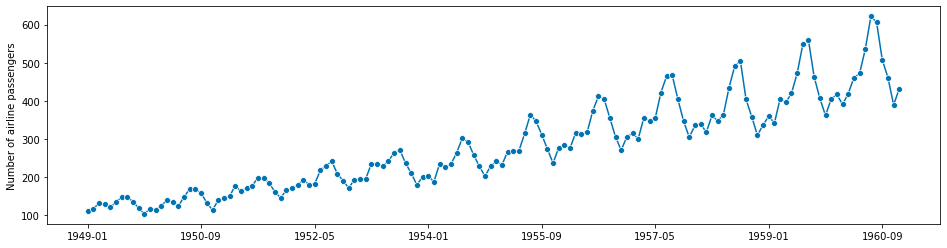

In [8]:
y = load_airline()
plot_series(y)

108 36


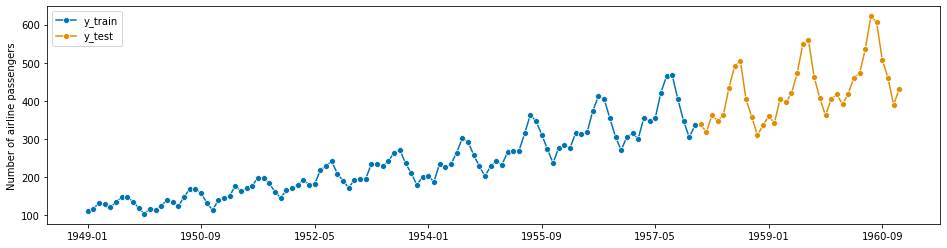

In [9]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [10]:
fh = ForecastingHorizon(np.arange(len(y_test)) + 1, is_relative=True)
fh

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36],
           dtype='int64', is_relative=True)

## M4 style

Adapted from: https://github.com/mloning/sktime-m4/blob/master/scripts/replicate.py

In [11]:
import os
import socket
import time
from warnings import filterwarnings
from warnings import simplefilter

import numpy as np
import pandas as pd
from joblib import Parallel
from joblib import delayed
from joblib.externals.loky.process_executor import TerminatedWorkerError
from sklearn.base import clone
from sktime.exceptions import FitFailedWarning
from sktime.performance_metrics.forecasting import mase_loss
from sktime.performance_metrics.forecasting import smape_loss

from config import DATADIR
from config import DATASETS
from config import N_JOBS
# from config import REPLICATED_RESULTS_DIR
from config import SELECTED_FORECASTERS
from config import TESTDIR
from config import TRAINDIR
from construct import construct_forecasters
from utils import load_metadata
from utils import save_results

In [57]:
# def _fit_evaluate(i, forecaster, y_train, y_test, fh, sp):
def _fit_evaluate(forecaster, y_train, y_test, fh, sp):
    """Fit and evaluate single forecaster on single series"""
    # silence warnings
    filterwarnings("ignore", module="sklearn")
    filterwarnings("ignore", module="statsmodels")
    simplefilter("ignore", category=FitFailedWarning)
    simplefilter("ignore", category=FutureWarning)
    simplefilter("ignore", category=UserWarning)

    # remove padding
    y_train = y_train[~np.isnan(y_train)]
    y_test = y_test[~np.isnan(y_test)]

    # check forecasting horizon
    assert len(fh) == len(y_test)

    # get data into expected format
    y_train = pd.Series(y_train)
    n_timepoints = len(y_train)

    # adjust test index to be after train index
    index = np.arange(n_timepoints, n_timepoints + len(y_test))
    y_test = pd.Series(y_test, index=index)
    assert y_test.index[0] == y_train.index[-1] + 1

    # clone forecaster
    f = clone(forecaster)

    # fit
    start = time.time()
    # f.fit(y_train, fh=fh)  # original
    f.fit(y_train)  # new
    fit_time = time.time() - start

    try:
        print(f.cv_results_)
    except:
        pass

    # predict
    start = time.time()
    # y_pred = f.predict()  # original
    y_pred = f.predict(fh)
    predict_time = time.time() - start

    # compute errors
    mase = mase_loss(y_test, y_pred, y_train, sp=sp)
    smape = smape_loss(y_test, y_pred)

    # collect and return results
    results = {
        # "id": i,
        "y_pred": y_pred,
        "mase": mase,
        "smape": smape,
        "fit_time": fit_time,
        "predict_time": predict_time
    }
    return results

In [13]:
sp=12

In [14]:
FORECASTERS = construct_forecasters(sp=sp, fh=fh)

In [15]:
l = list(FORECASTERS.keys())
print(f"Number: {len(l)},\n{l}")

Number: 24,
['Naive', 'sNaive', 'Naive2', 'SES', 'Holt', 'Damped', 'Theta', 'ARIMA', 'Com', 'MLP', '260', 'LR', 'KNN', 'RF', 'LR-s', 'KNN-s', 'RF-s', 'LR-t-s', 'KNN-t-s', 'RF-t-s', 'KNN_theta', 'RF_theta', 'KNN_theta_t', 'RF_theta_t']


In [16]:
print(f"Number: {len(SELECTED_FORECASTERS)},\n{SELECTED_FORECASTERS}")

Number: 11,
['Naive', 'Naive2', 'sNaive', 'SES', 'Holt', 'Damped', 'Com', 'ARIMA', 'Theta', '260', 'MLP']


In [17]:
FORECASTERS = {
    name: forecaster for name, forecaster in FORECASTERS.items()
    if name in SELECTED_FORECASTERS
}
l = list(FORECASTERS.keys())
print(f"Number: {len(l)},\n{l}")

Number: 11,
['Naive', 'sNaive', 'Naive2', 'SES', 'Holt', 'Damped', 'Theta', 'ARIMA', 'Com', 'MLP', '260']


## Add CV Models

In [42]:
cv = SlidingWindowSplitter(
    initial_window=int(len(y_train) * 0.5),
    start_with_window=True,
    window_length=36    
)

In [43]:
# Auto ARIMA
forecaster_param_grid = {"sp": [3, 6, 12, 24]}
forecaster = AutoARIMA(suppress_warnings=True)
gscv_arima = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=forecaster_param_grid, verbose=True
)
FORECASTERS.update({'auto_ARIMA': gscv_arima})

In [44]:
# Auto ETS
forecaster_param_grid = {
    "sp": [3, 4, 12, 24],
    # 'error': ["add", "mul"],
    # 'trend': ["add", "mul", None],
    # 'damped_trend': [True, False],
    # 'seasonal': ["add", "mul", None]
}
forecaster = AutoETS(auto=True)
gscv_ets = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=forecaster_param_grid, verbose=True
)
FORECASTERS.update({'auto_ETS': gscv_ets})

In [45]:
# Auto Exponential Smoothing (my version)
forecaster_param_grid = {
    "sp": [3, 4, 12, 24],
    "trend": ["add", "mul", None],
    "damped_trend": [True, False],
    "seasonal": ["add", "mul", None],
}
forecaster = ExponentialSmoothing()
gscv_expo = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=forecaster_param_grid, verbose=True
)
FORECASTERS.update({'auto_Expo': gscv_expo})

In [46]:
# Random Forest

regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {
    "deseasonalise__sp": [6, 12, 24],
    "detrend__forecaster__degree": [1, 2],
    "forecaster__window_length": [10, 12, 15, 20, 25],
}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(
    RandomForestRegressor(random_state=42), param_grid=regressor_param_grid
)
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalise", Deseasonalizer(model="multiplicative")),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster())),
        (
            "forecaster",
            ReducedRegressionForecaster(regressor=regressor, strategy="recursive"),
        ),
    ]
)
gscv_rf = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=forecaster_param_grid, verbose=True
)
FORECASTERS.update({'auto_rf': gscv_rf})

In [47]:
l = list(FORECASTERS.keys())
print(f"Number: {len(l)},\n{l}")

Number: 15,
['Naive', 'sNaive', 'Naive2', 'SES', 'Holt', 'Damped', 'Theta', 'ARIMA', 'Com', 'MLP', '260', 'auto_ARIMA', 'auto_Expo', 'auto_ETS', 'auto_rf']


In [48]:
# Convert to simple values
y_train_vals = y_train.reset_index(drop=True).values
y_test_vals = y_test.reset_index(drop=True).values
# print(y_train, y_train_vals)
# print(y_test, y_test_vals)

In [49]:
FORECASTERS_list = list(FORECASTERS.keys())
print(FORECASTERS_list)

['Naive', 'sNaive', 'Naive2', 'SES', 'Holt', 'Damped', 'Theta', 'ARIMA', 'Com', 'MLP', '260', 'auto_ARIMA', 'auto_Expo', 'auto_ETS', 'auto_rf']


In [58]:
all_results = []
for name, forecaster in FORECASTERS.items():
    print(f"{name} ...")    
    # iterate over individual series in data set
    results = _fit_evaluate(
        forecaster,
        y_train_vals,
        y_test_vals,
        fh,
        sp
    )       
    all_results.append(results)    
print("DONE")

72 folds for each of 72 candidates, totalling 5184 fits
{'mean_fit_time': array([0.21253467, 0.29326892, 0.00099778, 0.27430177, 0.33822107,
       0.        , 0.25535297, 0.35310173, 0.        , 0.28723955,
       0.35619211, 0.        , 0.22744203, 0.33314037, 0.00099373,
       0.26636434, 0.34814405, 0.00099635, 0.30832314, 0.40803075,
       0.00099587, 0.32028699, 0.4948535 , 0.        , 0.0508306 ,
       0.05189252, 0.0010004 , 0.03393602, 0.04886866, 0.        ,
       0.03689623, 0.04891181, 0.00099754, 0.03690624, 0.04886651,
       0.0009973 , 0.23846149, 0.25235319, 0.03590941, 0.2184279 ,
       0.27838349, 0.03993034, 0.27332377, 0.28335333, 0.06192422,
       0.26973486, 0.33667564, 0.07978272, 0.22650766, 0.24448919,
       0.04291415, 0.2595067 , 0.24241853, 0.04887199, 0.29030871,
       0.32228875, 0.06084824, 0.29122734, 0.33635473, 0.13318729,
       0.03593636, 0.03989291, 0.00700092, 0.03596473, 0.03992891,
       0.00698233, 0.03291774, 0.03996539, 0.0069809 , 

In [51]:
list(all_results[0].keys())

['y_pred', 'mase', 'smape', 'fit_time', 'predict_time']

In [52]:
all_dfs = []
for i, results in enumerate(all_results):
    df = pd.DataFrame({
        'Forecaster': [FORECASTERS_list[i]],
        'sMAPE': [round(results['smape'],4)],
        'MASE': [round(results['mase'],4)]
    })
    all_dfs.append(df)

In [53]:
final_results = pd.concat(all_dfs)
final_results.reset_index(drop=True, inplace=True)
final_results.sort_values('sMAPE')

,Forecaster,sMAPE,MASE
7,ARIMA,0.0412,0.5825
11,auto_ARIMA,0.0412,0.5825
14,auto_rf,0.0446,0.6465
4,Holt,0.0564,0.8202
9,MLP,0.0612,0.8965
10,260,0.0616,0.8972
13,auto_ETS,0.0621,0.8974
12,auto_Expo,0.0722,1.0442
5,Damped,0.0776,1.1283
8,Com,0.0855,1.2359
